In [1]:
from pytorch_libraries.utility_dataset import *
from pytorch_libraries.model_GAN import *
from IPython.display import clear_output
from pylab import *
%matplotlib inline
#%qtconsole #--style monokai

In [2]:
from torchvision import datasets, transforms

BATCHSIZE = 50
SEEDDIM   = 100

trnset = datasets.CIFAR10(root='../data', download=True,
                          transform=transforms.Compose([
                                transforms.Resize(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))
batches = DataLoader(trnset, batch_size=BATCHSIZE, shuffle=False)

Files already downloaded and verified


In [3]:
# define target
target_real = Variable(torch.ones(BATCHSIZE,1)).cuda()
target_fake = Variable(torch.zeros(BATCHSIZE,1)).cuda()

# define model
dis = DIS(ndf=32, nc=3).cuda()
gen = GEN(nz=100, ngf=32, nc=3).cuda()
gen.apply(weights_init)
dis.apply(weights_init)

# defile opt
gen_optimizer = optim.Adam(gen.parameters(), lr=2e-3)
dis_optimizer = optim.Adam(dis.parameters(), lr=2e-3)

In [7]:
gen.train()
dis.train()
# begin Training
for epoch in range(30):
    running_gen_loss = 0.0
    running_dis_loss = 0.0
    for i, batch in enumerate(batches):
        
        # 1. training dis
        dis_optimizer.zero_grad()
        
        # 1.1 get input
        inputs_real = Variable(batch[0]).cuda()
        gen_seed    = Variable(torch.randn(BATCHSIZE,SEEDDIM,1,1)).cuda()
        inputs_fake = gen(gen_seed)#.detach() 
        
        # 1.2 get scores for real and fake
        score_real = dis(inputs_real)
        score_fake = dis(inputs_fake)
        
        # 1.3 calc loss
        dis_loss = discriminator_loss(score_real, score_fake, 
                                      target_real,target_fake)
        # 1.4 backprop and optimize
        dis_loss.backward()
        dis_optimizer.step()
        
        # 2. training gen
        gen_optimizer.zero_grad()
        
        gen_seed = Variable(torch.randn(BATCHSIZE,SEEDDIM,1,1)).cuda()
        gen_loss = generator_loss( dis(gen(gen_seed)), target_real)        
        
        gen_loss.backward()
        gen_optimizer.step()   
        
        # TRAINING DESHBOARD #
        ##################################################################
        running_gen_loss += gen_loss.data[0]
        running_dis_loss += dis_loss.data[0]
        if i % 100 == 99:    # print every 100 mini-batches
            print('[{:5d}, {:5d}] gen-loss: {:8.6f}, dis-loss: {:8.6f}'.
                  format(epoch+1, i+1, running_gen_loss/100, running_dis_loss/100))
            clear_output(wait=True)
            running_gen_loss = 0.0
            running_dis_loss = 0.0
        ##################################################################

[   30,  1000] gen-loss: 7.946667, dis-loss: 0.087961


In [8]:
gen_seed    = Variable(torch.randn(40,SEEDDIM,1,1)).cuda()
inputs_fake = gen(gen_seed)
images = inputs_fake.cpu()
images = images.data.numpy()
images = np.transpose(images,[0,2,3,1])

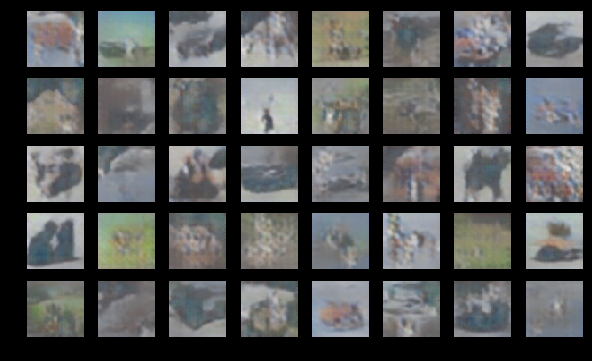

In [22]:
plt.rc("figure",facecolor="k",figsize=(10,6))
plt.style.use('dark_background')

nrow = 5
ncol = 8

for row in range(nrow):
    for col in range(ncol):
        index = ncol*row + col
        plt.subplot(nrow,ncol, index+1)
        image = images[index]
        image = 0.5*(image+1)
        plt.imshow(image)
        plt.axis('off')
        plt.axis('off')
#plt.savefig('../plot/dcgan.png',dpi=300)